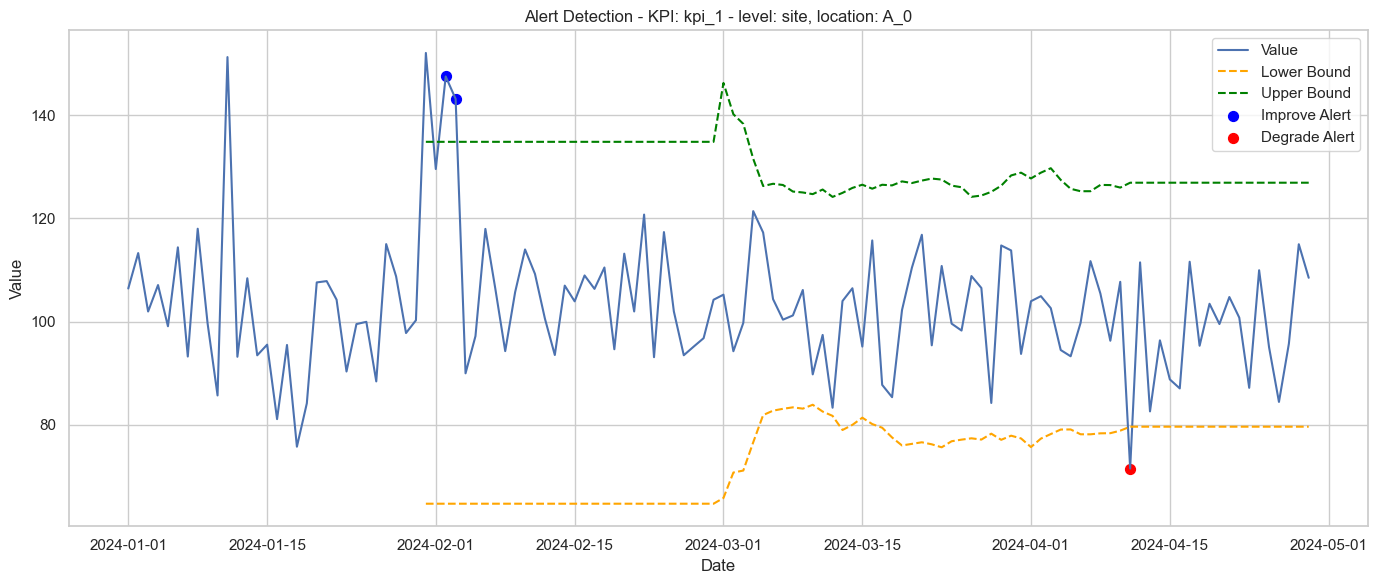

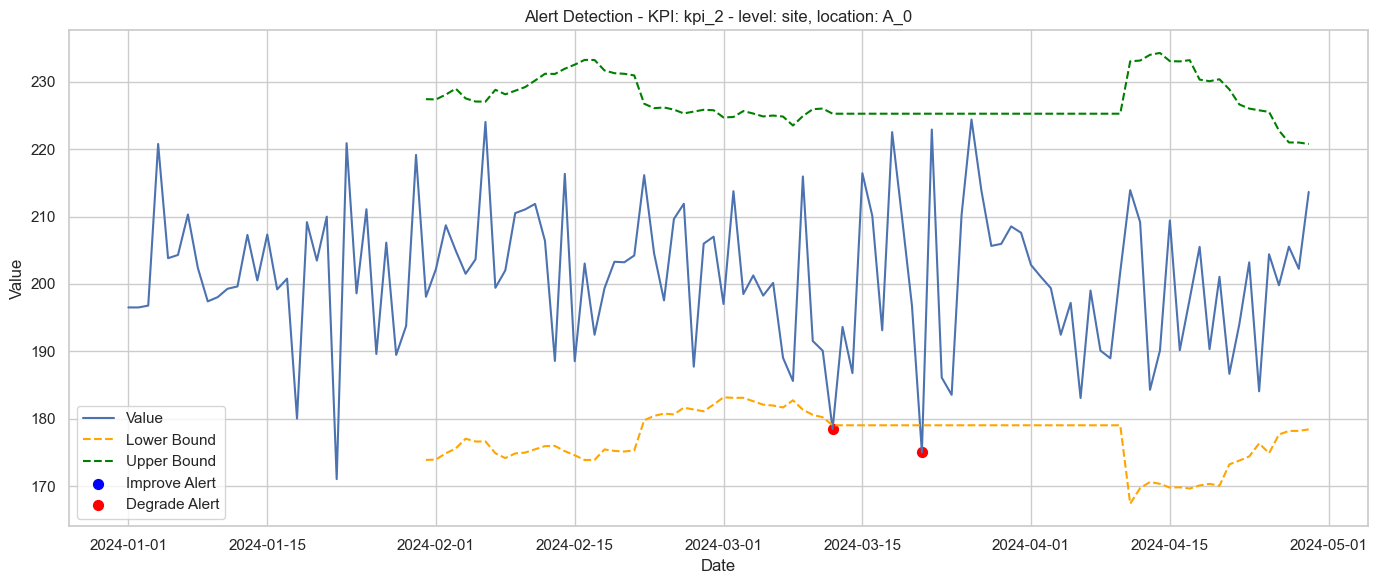

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def detect_alerts_with_freeze_bounds(df, window=30, alpha=2.5):
    df['date'] = pd.to_datetime(df['date'])
    results = []
    group_cols = ['site_id', 'level', 'location', 'kpi_name']
    for key, group in df.groupby(group_cols):
        gran = group['granularity'].iloc[0]
        ts = group.set_index('date').sort_index()
        ts_resampled = ts['kpi_value'].resample(gran).mean().dropna()
        if len(ts_resampled) < window:
            continue

        lb = pd.Series(index=ts_resampled.index, dtype=float)
        ub = pd.Series(index=ts_resampled.index, dtype=float)
        alert = pd.Series(0, index=ts_resampled.index)
        alert_status = pd.Series('', index=ts_resampled.index)
        pct_improve = pd.Series(np.nan, index=ts_resampled.index)
        pct_degrade = pd.Series(np.nan, index=ts_resampled.index)

        freeze_start = None
        freeze_lb = None
        freeze_ub = None
        last_normal_value = None

        for i in range(len(ts_resampled)):
            if i < window:
                continue

            current_date = ts_resampled.index[i]
            val = ts_resampled.iloc[i]

            if freeze_start is None:
                window_slice = ts_resampled.iloc[i - window:i]
                median = window_slice.median()
                std = window_slice.std()
                curr_lb = median - alpha * std
                curr_ub = median + alpha * std
                lb.iloc[i] = curr_lb
                ub.iloc[i] = curr_ub

                if val < curr_lb or val > curr_ub:
                    alert.iloc[i] = 1
                    if last_normal_value is not None:
                        change_pct = ((val - last_normal_value) / last_normal_value) * 100
                        if val > curr_ub:
                            alert_status.iloc[i] = 'improve'
                            pct_improve.iloc[i] = change_pct
                        elif val < curr_lb:
                            alert_status.iloc[i] = 'degrade'
                            pct_degrade.iloc[i] = change_pct
                    freeze_start = current_date
                    freeze_lb = curr_lb
                    freeze_ub = curr_ub
                else:
                    last_normal_value = val
            else:
                days_in_freeze = (current_date - freeze_start).days
                if days_in_freeze < window:
                    lb.iloc[i] = freeze_lb
                    ub.iloc[i] = freeze_ub
                    if val < freeze_lb or val > freeze_ub:
                        alert.iloc[i] = 1
                        if last_normal_value is not None:
                            change_pct = ((val - last_normal_value) / last_normal_value) * 100
                            if val > freeze_ub:
                                alert_status.iloc[i] = 'improve'
                                pct_improve.iloc[i] = change_pct
                            elif val < freeze_lb:
                                alert_status.iloc[i] = 'degrade'
                                pct_degrade.iloc[i] = change_pct
                    else:
                        alert.iloc[i] = 0
                        alert_status.iloc[i] = ''
                        last_normal_value = val
                else:
                    window_slice = ts_resampled.iloc[i - window:i]
                    median = window_slice.median()
                    std = window_slice.std()
                    curr_lb = median - alpha * std
                    curr_ub = median + alpha * std
                    lb.iloc[i] = curr_lb
                    ub.iloc[i] = curr_ub
                    if val < curr_lb or val > curr_ub:
                        alert.iloc[i] = 1
                        if last_normal_value is not None:
                            change_pct = ((val - last_normal_value) / last_normal_value) * 100
                            if val > curr_ub:
                                alert_status.iloc[i] = 'improve'
                                pct_improve.iloc[i] = change_pct
                            elif val < curr_lb:
                                alert_status.iloc[i] = 'degrade'
                                pct_degrade.iloc[i] = change_pct
                        freeze_start = current_date
                        freeze_lb = curr_lb
                        freeze_ub = curr_ub
                    else:
                        alert.iloc[i] = 0
                        alert_status.iloc[i] = ''
                        last_normal_value = val
                        freeze_start = None
                        freeze_lb = None
                        freeze_ub = None

        df_out = pd.DataFrame({
            'date': ts_resampled.index,
            'site_id': key[0],
            'level': key[1],
            'location': key[2],
            'kpi_name': key[3],
            'value': ts_resampled.values,
            'lower_bound': lb.values,
            'upper_bound': ub.values,
            'alert': alert.values,
            'alert_status': alert_status.values,
            'percentage_alert_improve': pct_improve.values,
            'percentage_alert_degrade': pct_degrade.values,
            'granularity': gran
        })

        results.append(df_out)

    return pd.concat(results, ignore_index=True)

def plot_alerts(df, level=None, location=None, kpi_name=None):
    sns.set(style='whitegrid')
    subset = df
    if level:
        subset = subset[subset['level'] == level]
    if location:
        subset = subset[subset['location'] == location]
    if kpi_name:
        if isinstance(kpi_name, list):
            subset = subset[subset['kpi_name'].isin(kpi_name)]
        else:
            subset = subset[subset['kpi_name'] == kpi_name]
    if subset.empty:
        print("No data to plot for the selected filter.")
        return
    kpis = subset['kpi_name'].unique()
    for kpi in kpis:
        sub = subset[subset['kpi_name'] == kpi]
        plt.figure(figsize=(14,6))
        plt.plot(sub['date'], sub['value'], label='Value')
        plt.plot(sub['date'], sub['lower_bound'], linestyle='--', color='orange', label='Lower Bound')
        plt.plot(sub['date'], sub['upper_bound'], linestyle='--', color='green', label='Upper Bound')
        plt.scatter(sub[sub['alert_status'] == 'improve']['date'], sub[sub['alert_status'] == 'improve']['value'],
                    color='blue', label='Improve Alert', s=50)
        plt.scatter(sub[sub['alert_status'] == 'degrade']['date'], sub[sub['alert_status'] == 'degrade']['value'],
                    color='red', label='Degrade Alert', s=50)
        title = f"Alert Detection - KPI: {kpi}"
        filters = []
        if level: filters.append(f"level: {level}")
        if location: filters.append(f"location: {location}")
        plt.title(title + (" - " + ", ".join(filters) if filters else ""))
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    np.random.seed(42)
    dates = pd.date_range('2024-01-01', periods=120)
    data = []
    levels = ['nation', 'region', 'site']
    locations = {
        'nation': ['Indonesia', 'Malaysia'],
        'region': ['Sumatra', 'Sulawesi'],
        'site': ['A_0', 'A_1', 'B_0', 'B_1']
    }
    for level in levels:
        for loc in locations[level]:
            for kpi in ['kpi_1', 'kpi_2']:
                site = loc if level == 'site' else 'all_sites'
                gran = 'D'
                values = np.random.normal(100 if kpi == 'kpi_1' else 200, 10, len(dates))
                if kpi == 'kpi_1' and loc == 'A_0':
                    values[[10, 30, 31, 32, 33]] += 50
                if kpi == 'kpi_2' and loc == 'B_0':
                    values[[15, 40, 41, 42, 43]] -= 70
                df_temp = pd.DataFrame({
                    'date': dates,
                    'site_id': site,
                    'level': level,
                    'location': loc,
                    'granularity': gran,
                    'kpi_name': kpi,
                    'kpi_value': values
                })
                data.append(df_temp)
    df = pd.concat(data, ignore_index=True)
    out = detect_alerts_with_freeze_bounds(df)
    plot_alerts(out, level='site', location='A_0', kpi_name=['kpi_1', 'kpi_2'])

In [13]:
df

,date,site_id,level,location,granularity,kpi_name,kpi_value
0,2024-01-01,all_sites,nation,Indonesia,D,kpi_1,104.967142
1,2024-01-02,all_sites,nation,Indonesia,D,kpi_1,98.617357
2,2024-01-03,all_sites,nation,Indonesia,D,kpi_1,106.476885
3,2024-01-04,all_sites,nation,Indonesia,D,kpi_1,115.230299
4,2024-01-05,all_sites,nation,Indonesia,D,kpi_1,97.658466
...,...,...,...,...,...,...,...
1915,2024-04-25,B_1,site,B_1,D,kpi_2,194.573262
1916,2024-04-26,B_1,site,B_1,D,kpi_2,192.122162
1917,2024-04-27,B_1,site,B_1,D,kpi_2,193.791524
1918,2024-04-28,B_1,site,B_1,D,kpi_2,198.318562


In [14]:
df[df['location'] == "A_0"]

,date,site_id,level,location,granularity,kpi_name,kpi_value
960,2024-01-01,A_0,site,A_0,D,kpi_1,106.427228
961,2024-01-02,A_0,site,A_0,D,kpi_1,113.291525
962,2024-01-03,A_0,site,A_0,D,kpi_1,101.965212
963,2024-01-04,A_0,site,A_0,D,kpi_1,107.090038
964,2024-01-05,A_0,site,A_0,D,kpi_1,99.102643
...,...,...,...,...,...,...,...
1195,2024-04-25,A_0,site,A_0,D,kpi_2,204.404747
1196,2024-04-26,A_0,site,A_0,D,kpi_2,199.803622
1197,2024-04-27,A_0,site,A_0,D,kpi_2,205.524900
1198,2024-04-28,A_0,site,A_0,D,kpi_2,202.239141


In [15]:
out

,date,site_id,level,location,kpi_name,value,lower_bound,upper_bound,alert,alert_status,percentage_alert_improve,percentage_alert_degrade,granularity
0,2024-01-01,A_0,site,A_0,kpi_1,106.427228,NaN,NaN,0,,NaN,NaN,D
1,2024-01-02,A_0,site,A_0,kpi_1,113.291525,NaN,NaN,0,,NaN,NaN,D
2,2024-01-03,A_0,site,A_0,kpi_1,101.965212,NaN,NaN,0,,NaN,NaN,D
3,2024-01-04,A_0,site,A_0,kpi_1,107.090038,NaN,NaN,0,,NaN,NaN,D
4,2024-01-05,A_0,site,A_0,kpi_1,99.102643,NaN,NaN,0,,NaN,NaN,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2024-04-25,all_sites,region,Sumatra,kpi_2,211.033019,175.428970,223.227552,0,,NaN,NaN,D
1916,2024-04-26,all_sites,region,Sumatra,kpi_2,201.142276,175.104054,223.552468,0,,NaN,NaN,D
1917,2024-04-27,all_sites,region,Sumatra,kpi_2,201.503018,176.175857,224.590072,0,,NaN,NaN,D
1918,2024-04-28,all_sites,region,Sumatra,kpi_2,196.363878,177.170799,225.474495,0,,NaN,NaN,D


In [16]:
out[out['alert'] == 1]

,date,site_id,level,location,kpi_name,value,lower_bound,upper_bound,alert,alert_status,percentage_alert_improve,percentage_alert_degrade,granularity
30,2024-01-31,A_0,site,A_0,kpi_1,152.083828,64.706468,134.855927,1,,NaN,NaN,D
32,2024-02-02,A_0,site,A_0,kpi_1,147.528226,64.706468,134.855927,1,improve,13.848748,NaN,D
33,2024-02-03,A_0,site,A_0,kpi_1,143.180158,64.706468,134.855927,1,improve,10.493308,NaN,D
101,2024-04-11,A_0,site,A_0,kpi_1,71.514574,79.634889,126.929884,1,degrade,NaN,-33.608825,D
191,2024-03-12,A_0,site,A_0,kpi_2,178.466099,179.025721,225.256399,1,degrade,NaN,-6.113008,D
200,2024-03-21,A_0,site,A_0,kpi_2,175.005943,179.025721,225.256399,1,degrade,NaN,-11.052380,D
273,2024-02-03,A_1,site,A_1,kpi_1,125.797093,74.684478,123.134495,1,improve,26.917547,NaN,D
531,2024-02-21,B_0,site,B_0,kpi_1,125.581993,74.912592,121.657004,1,improve,32.917133,NaN,D
640,2024-02-10,B_0,site,B_0,kpi_2,128.171036,159.087055,241.737680,1,degrade,NaN,-33.493641,D
641,2024-02-11,B_0,site,B_0,kpi_2,143.748764,159.087055,241.737680,1,degrade,NaN,-25.410551,D
